<a href="https://colab.research.google.com/github/Emmit179/cell_research/blob/main/VAETutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pickle
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import os
import glob
import pandas
from tqdm import tqdm
from scipy import ndimage
from IPython.display import display, HTML
from matplotlib import pyplot as plt
device = "cpu"
Hsize=4;Ksize=191;Lsize=191;
dsf_data=[];
proj_data=[];

In [2]:
# Download data from Google Drive
import gdown
url='https://drive.google.com/drive/folders/1IUPIpENqeIxgMK-bCSdkKLROCjJwHkE5'
gdown.download_folder(url, quiet=True)

['/content/data/DsfsProjs_0104.jld2']

In [3]:
def compress(data, kernel):
  # print("Start size: ", data.shape)
  #data = data.unsqueeze(0)

  pool = nn.AvgPool2d(kernel_size=kernel)

  pooled_data = pool(data)

  #pooled_data = pooled_data.squeeze(0)

  # print("Compressed size: ",pooled_data.shape)
  return(pooled_data)

In [4]:
def reflect(S0):
    S0_slice = S0[1:, :]
    S0_reflected = np.concatenate((np.flipud(S0_slice), S0), axis=0)
    S0_reflected = np.concatenate((np.fliplr(S0_reflected[:, 1:]), S0_reflected), axis=1)
    return S0_reflected

In [42]:
def displayVAE(num):
    plt.figure(figsize=(32,8))
    dat=data_all_raw.dataset.tensors[0][num].to(device)
    dat=dat.detach().to("cpu");
    dat=np.reshape(dat,(191,191,4))
    for idx in range(4):
        if idx != 0:
          datTemp = dat.T
          datTemp = compress(datTemp, 2*(idx))
          datTemp = datTemp.T
          size = 2*(idx)
        else:
          datTemp = dat
          size = 1
        plt.subplot(1,4,idx+1)
        plt.imshow(reflect(datTemp[:,:,num]).T)
        plt.axis("off")
        plt.title("Kernel Size: " + str(size) + "\n Shape: " + str(list(datTemp.shape)), fontsize=32)

    plt.tight_layout()

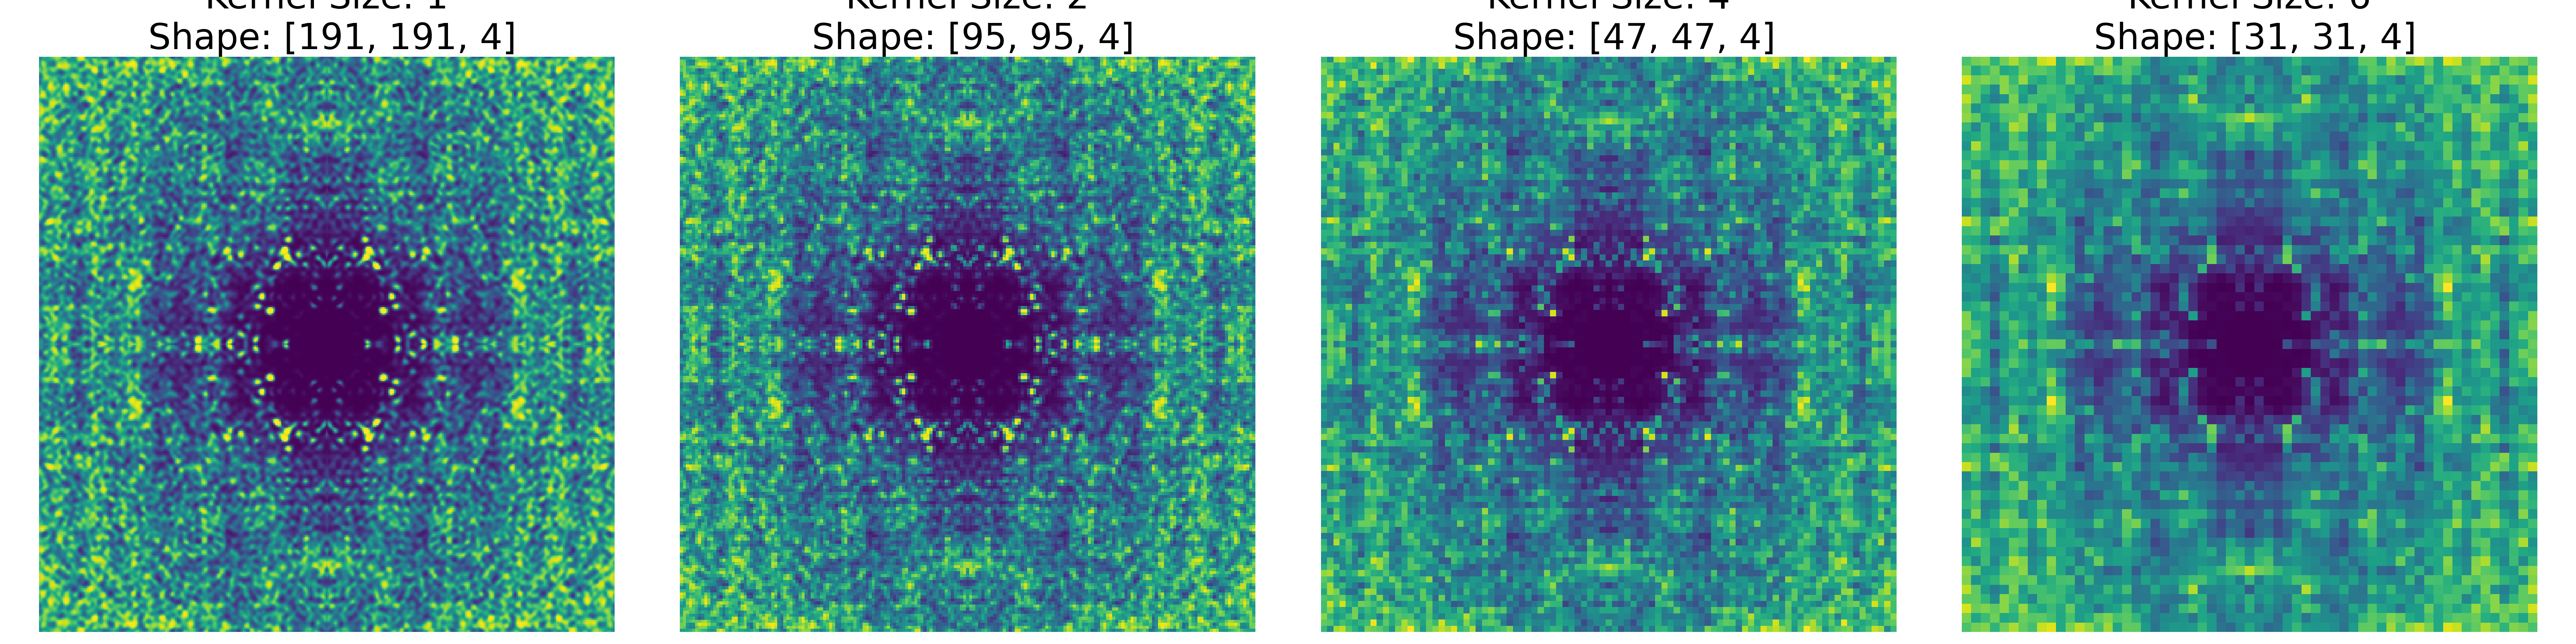

In [44]:
import warnings
warnings.filterwarnings('ignore')
dataDsfsProjs=h5py.File("/content/data/DsfsProjs_0104.jld2","r")
Bsize=64
data_projs=dataDsfsProjs["projs"][:]
data_dsfs=dataDsfsProjs["dsfs"][:]
normdata_dsfs=np.zeros((len(data_dsfs),47**2*4))
normdata_dsfs_raw=np.zeros((len(data_dsfs),191**2*4))
typename=['Libration','Libration','Bending','Bending','Stretching','Stretching', 'Stretching', 'Stretching', 'Lattice', 'Lattice', 'Lattice', 'Lattice', 'Lattice', 'Lattice', 'Lattice', 'Lattice' ]
Ndat=len(data_projs)
dat_type=np.zeros((Ndat,4))
for i in range(len(data_dsfs)):
    dat=1*data_dsfs[i,:]
    dat=np.tanh(dat/np.mean(dat)/2)
    dat=np.reshape(dat,(191,191,4))
    dat = torch.from_numpy(dat)
    datRaw = dat
    dat = dat.T
    dat = compress(dat, 4)
    dat = dat.T
    dat = np.reshape(dat,-1)
    datRaw = np.reshape(datRaw,-1)
    normdata_dsfs[i,:]=dat
    normdata_dsfs_raw[i,:]=datRaw
    dat=data_projs[i]
    dat_type[i,:]=[(dat[2]+dat[7])/2, dat[0], dat[3], dat[8]]
    dat_type[i,:]/=sum(dat)

data_mode=np.dot((np.round(dat_type*30)>0),[8,4,2,1])

data_all=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(normdata_dsfs,dtype=torch.float32), torch.tensor(data_mode,dtype=torch.float32)), batch_size=Bsize, shuffle=True)
data_all_raw=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(normdata_dsfs_raw,dtype=torch.float32)), batch_size=Bsize, shuffle=True)

displayVAE(1)

In [7]:
latent_dims=10
class VAE(nn.Module):
    def __init__(self, image_channels=1, input_dims=[Hsize,Ksize,Lsize],inter_dims=[512,128,32], lat_dim=latent_dims):
        super(VAE, self).__init__()
        encoders=[
            nn.Linear(input_dims[0]*input_dims[1]*input_dims[2], inter_dims[0]),
            nn.ReLU()]
        decoders=[nn.ReLU()]

        for i in range(np.size(inter_dims)-1):
            encoders.append(nn.Linear(inter_dims[i],inter_dims[i+1]))
            encoders.append(nn.ReLU())
            decoders.append(nn.Linear(inter_dims[-1-i],inter_dims[-2-i]))
            decoders.append(nn.ReLU())

        decoders.append(nn.Linear(inter_dims[0],input_dims[0]*input_dims[1]*input_dims[2]))
        decoders.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*encoders)
        self.decoder = nn.Sequential(*decoders)

        self.fc1 = nn.Linear(inter_dims[-1], lat_dim)
        self.fc2 = nn.Linear(inter_dims[-1], lat_dim)
        self.fc3 = nn.Linear(lat_dim, inter_dims[-1])


    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_().to(device)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    MSE =  ((x - recon_x)**2).sum()
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    # LAT = ((mu - y)**2).sum()
    return MSE,KLD

In [8]:
import copy
epochs = 100
firsttrain=True
if firsttrain:
    vae = VAE(input_dims=[4,47,47],inter_dims=[256,64,16],lat_dim=3)
    autoencoder=vae.to(device)
    opt = torch.optim.Adam(autoencoder.parameters(),betas=(0.9,0.99))

for i,param in enumerate(autoencoder.parameters()):
    if i >= 0:
        param.requires_grad=True
for g in opt.param_groups:
    g['lr'] = 3e-5

losses=np.empty((3,epochs))
losses[:,1:]=np.nan
import time
np.set_printoptions(suppress=True)
bestloss=1e10

for epoch in range(epochs):
    batchloss=torch.tensor(losses[:,0],dtype=torch.float32)
    for x_input, y in data_all:
        x_input = x_input[0].to(device)
   #     print(x_input.shape)
        opt.zero_grad()
        x_output,mu,logvar = autoencoder(x_input)
        mse,kld=loss_fn(x_output, x_input, mu, logvar)
        kld*=0.1;
        loss=mse+kld
        batchloss+=torch.tensor([loss,mse,kld])
        loss=loss/x_input.shape[0]
        loss.backward()
        opt.step()
    losses[:,epoch]=(batchloss/len(data_all.dataset)).detach().to('cpu').numpy()

    if batchloss[0] < bestloss:
        bestloss = batchloss[0]
#        print('bestloss: ',bestloss)
        best_model_wts=copy.deepcopy(autoencoder.state_dict())
        state={'state_dict':autoencoder.state_dict(),
              'best_loss':bestloss,
              'optimizer':opt.state_dict()}
        savefilename='VAE_PhononProj.pt'
        torch.save(state,savefilename)

    if epoch % 10 ==0:
        print(losses[:,epoch])
 #       plot1.set_ydata(losses[0])
 #       figure.canvas.draw()
 #       figure.canvas.flush_events()

    if epoch % 500 ==499:
        loadstate=torch.load(savefilename)
        autoencoder.load_state_dict(loadstate['state_dict'])
        opt.load_state_dict(loadstate['optimizer'])


[9.23526001 9.23513412 0.00012504]
[7.97587252 7.95399284 0.02187957]
[7.73896503 7.61768198 0.12128317]
[7.02941847 6.92765093 0.10176755]
[6.08312607 6.01436853 0.06875784]
[6.71756506 6.66936398 0.04820209]
[4.78587866 4.73632717 0.04955151]
[5.08705997 5.04197216 0.04508832]
[4.44660044 4.40958881 0.03701178]
[4.58394051 4.543643   0.04029654]
[4.4957571  4.45788097 0.03787643]
[4.43335772 4.4013052  0.03205237]
[5.51691771 5.48302603 0.03389073]
[4.49070692 4.46968651 0.02102019]
[4.89931154 4.86568165 0.03363022]
[4.55817842 4.533216   0.02496253]
[4.90703249 4.88110447 0.02592828]
[4.3296752  4.30462646 0.0250486 ]
[4.19792128 4.1817317  0.01618992]
[4.65762329 4.62928009 0.02834287]
[4.20024824 4.15460539 0.04564296]
[4.48624706 4.45238447 0.03386241]
[4.42714119 4.40779686 0.01934394]
[4.17462587 4.15561152 0.01901406]
[4.29751301 4.2728405  0.02467309]
[4.04273129 4.01956415 0.0231674 ]
[4.71480131 4.69722795 0.01757301]
[4.324471   4.3135581  0.01091324]
[3.90174675 3.887389

In [9]:
def displayResult(num):
    plt.figure(figsize=(20,8))
    dat=data_all.dataset.tensors[0][num].to(device)
    recon,lat,_=autoencoder(dat)
    dat=dat.detach().to("cpu");recon=recon.detach().to("cpu");lat=lat.detach().to("cpu");
    dat=np.reshape(dat,(47,47,4))
    recon=np.reshape(recon,(47,47,4))
    for idx in range(4):
        plt.subplot(2,5,idx+1)
        plt.imshow(reflect(dat[:,:,idx]).T)
        plt.axis("off")
        plt.subplot(2,5,idx+6)
        plt.imshow(reflect(recon[:,:,idx]).T)
        plt.axis("off")
    plt.subplot(2,5,10)
    plt.plot(lat);#plt.axis("equal");
    plt.tight_layout()
    displayResult(170)

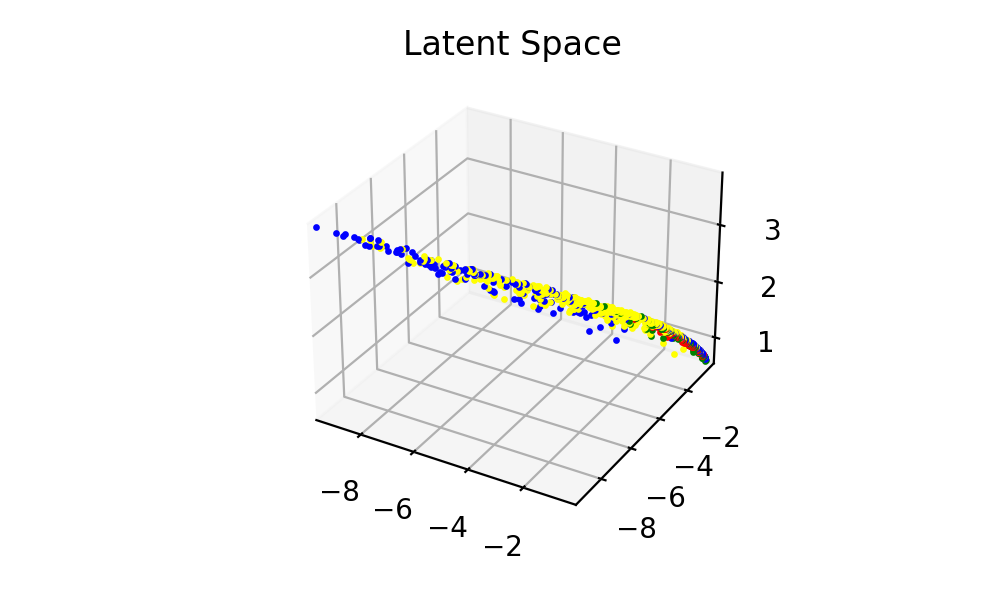

In [41]:
coords = []
color = []
data_all_plot=torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(normdata_dsfs,dtype=torch.float32), torch.tensor(data_mode,dtype=torch.float32)), batch_size=1, shuffle=True)
for x_input, mode in data_all_plot:
    x_input = x_input[0].to(device)
    mode = mode[0].detach().numpy()
    x_output,mu,logvar = autoencoder(x_input)
    mu=mu.cpu().detach().numpy()
    coords.append([mu[0], mu[2], mu[1]])
    color.append(mode)

fig = plt.figure(figsize = (5, 3))
plot = plt.axes(projection ="3d")

color_map = {"Libration": "green", "Bending": "red", "Stretching": "blue", "Lattice": "yellow"}
i = 0
for x,y,z in coords:
  plot.scatter3D(x, y, z, s=2, color = color_map[typename[int(color[i] - 1)]])
  i += 1

plot.set_xlim([min([coord[0] for coord in coords]), max([coord[0] for coord in coords])])
plot.set_ylim([min([coord[1] for coord in coords]), max([coord[1] for coord in coords])])
plot.set_zlim([min([coord[2] for coord in coords]), max([coord[2] for coord in coords])])
plt.title("Latent Space")

plt.show()